# BruteForce Searching Demo

Demo for unsupervised brute force shaplets searching for anomaly detection 

In [25]:
import sys
sys.path.append('../')

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


## Set up the dataset

### Load the data

Download the data (if needed):

In [26]:
# data_name = "Trace"
# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)
# np.save(f'../demo/data/{data_name}_train', X_train)
# np.save(f'../demo/data/{data_name}_train_labels', y_train)
# np.save(f'../demo/data/{data_name}_test', X_test)
# np.save(f'../demo/data/{data_name}_test_labeles', y_test)

Or load the data from saved numpy arrays:

In [27]:
data_name = "Trace"
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')

### Preprocessing

#### Get statistics of the entire data:

In [28]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

# if needed use label encoder to transform the labels from strings to integers
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# le.classes_

X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of training data: (100, 275, 1)
Shape of test data: (100, 275, 1)
The different classes: {1, 2, 3, 4}
Shape of the total data: (200, 275, 1)
Number of total samples in each class: [50, 50, 50, 50]


Use LabelEncoder in case the name of the labels are strings:

In [29]:
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# print('The positions are the new labels', le.classes_)


Plot one sample per class (first channel in case multivariate):

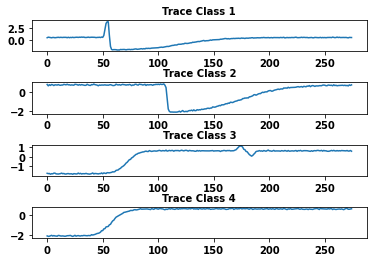

In [30]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# NOTE: modify if the labels start from 0 or 1
for i in range(n_class):
    ts = X_train[y_train==i+1][0,:,0]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

- First the train and test set are merged together
- A proportion "normal_prop" of time series from "normal_class" is selected randomly in the train set
- A proportion "alpha" of the latter set of normal train series is selected randomly from the other classes to represent the anomalies in the train set
- All the other series go in the test set

In [31]:
# Set seed for determinism
np.random.seed(0)

X_train = X_train[np.logical_or(y_train==3, y_train==4)]
y_train = y_train[np.logical_or(y_train==3, y_train==4)]

X_test = X_test[np.logical_or(y_test==3, y_test==4)]
y_test = y_test[np.logical_or(y_test==3, y_test==4)]
# Set up anomaly detection dataset

normal_class = 4 # choose the normal class
normal_prop = 0.2 # proportion of normal samples that go in train set
alpha = 0.1 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)


Get statistics of the anomaly detection dataset:

In [32]:
N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))

Trace dataset
number train ts is 11, each of length 275
They belong to two possible classes: {1, -1}
number test ts 89
number of normal train series: 10
number of anomalous train series: 1
number of normal test series: 40
number of anomalous test series: 49


#### Normalize:

Normalize globally:

In [33]:
# normalizer = Normalizer(scaler=StandardScaler())
# X_train_anomaly = normalizer.fit_normalize(X_train_anomaly)
# X_test_anomaly = normalizer.normalize(X_test_anomaly)

Or locally:

In [34]:
scaler = TimeSeriesScalerMeanVariance()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

#### Plot train and test set

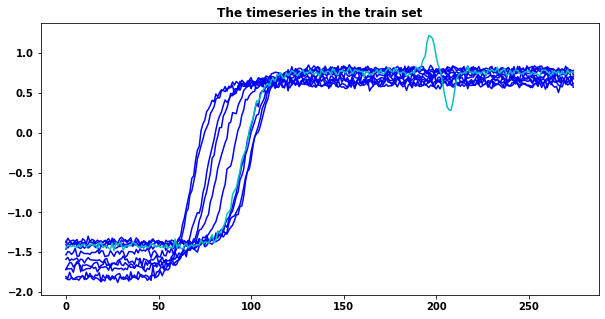

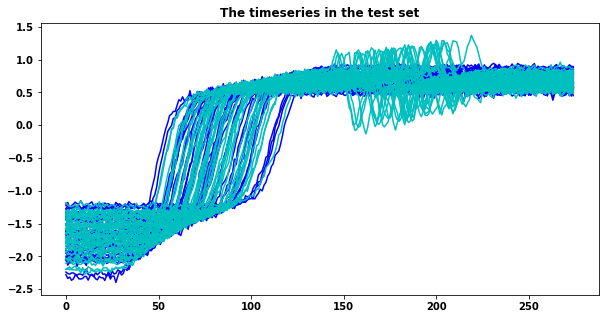

In [35]:
# only first channel in case multivariate
colors = ['r', 'b', 'g', 'y', 'c']

plt.figure(1, figsize=(10, 5))
for ts, label in zip(X_train_anomaly[:,:,0], y_train_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the train set', fontweight="bold")
plt.show()

plt.figure(2, figsize=(10, 5))
for ts, label in zip(X_test_anomaly[:,:,0], y_test_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the test set', fontweight="bold")
plt.show()


## Extract shapelets with different filtering modes

#### Shapelets with no filtering

Set up the extractor and hyperparameters:
- K_star: number of shapelets in proportion to length of time series Q
- L_star: length of shapelets in proportion to length of time series
- reverse: bool, whether to take the shapelets with max (True) or min score

In [36]:
extractor = Bruteforce_extractor_mv(train_data=X_train_anomaly, test_data=X_test_anomaly)

K_star = 0.02 # number of shapelets in proportion to length of time series
L_star = 0.2 # length of shapelets in proportion to length of time series
L = round(L_star * Q)

# REVERSE indicates whether the extracted shapelets are the furthest (True) or the nearest (False) to the majority of the time series
reverse = True
corr_threshold = None
pos_boundary = None

Extract the optimal shapelets:

In [37]:
# shapelets = extractor.extract_shapelets(K_star, L_star, pos_boundary=pos_boundary, corr_threshold=corr_threshold, reverse=reverse)
# S = shapelets.sequences
# print(f'Positions of the shapelets {shapelets.positions}')
# print(f'Scores {shapelets.scores}')

Are going to be extracted 6.000 shapelets of length 55.0000
Shapelets are going to be extracted in reverse order!


timeseries: 100%|██████████| 11/11 [09:45<00:00, 53.20s/it]


Time for shapelets extraction:
--- 586.2957870960236 seconds ---
Positions of the shapelets [159 160 164 165 163 158]
Scores [0.03082866 0.03082231 0.03082128 0.03081933 0.03081686 0.03081542]


NOTE: when extracting with no filter, the positions of the shapelets are 159 160 164 165 163 158.

Save the results:

In [38]:
# np.save(f'../Results/Trace34/s_reverse={reverse}_nofilter_L=55_positions_159_160_165_163_158', S)

Load the shapelets if are saved in Results:

In [39]:
# in case shapelets are already saved:
S = np.load(f'../Results/Trace34/s_reverse=True_nofilter_L=55_positions_159_160_165_163_158.npy')

# set manually the shapelets in extractor
extractor.shapelets = Candidateset()
extractor.shapelets.sequences = S

Plot the shapelets:

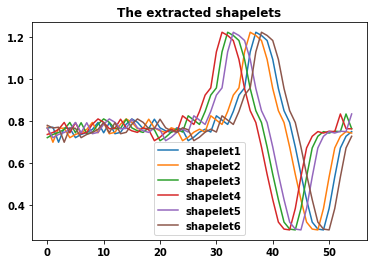

In [40]:
channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

In [41]:
# test the correlation of the shapelets
from src.util import max_corr
K = round(K_star*Q)

corr_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(len(S)):
        corr_matrix[i,j] = max_corr(S[i], S[j])
print(corr_matrix)

[[1.         0.99990169 0.99753359 0.99708069 0.99753504 0.99988799]
 [0.99990169 1.         0.99763949 0.99719513 0.9976413  0.99978741]
 [0.99753359 0.99763949 1.         0.99953612 0.99999913 0.99741937]
 [0.99708069 0.99719513 0.99953612 1.         0.99953529 0.99696002]
 [0.99753504 0.9976413  0.99999913 0.99953529 1.         0.99742053]
 [0.99988799 0.99978741 0.99741937 0.99696002 0.99742053 1.        ]]


#### Shapelets with (small) position filtering + distance filtering

Filter those candidates S with $|position(S_i) - position(S)| < posboundary$ $\forall S_i$ shapelet previous discovered

and $d(\hat{S}_i, \hat{S}) < threshold$  where $\hat{S}$ means the candidate shifted by its mean

In [42]:
K = round(K_star * Q)
pos_boundary = 10
corr_threshold = None
# just filter the scored candidates in different ways
shapelets = extractor.get_top_candidates(K, pos_boundary, corr_threshold, reverse)
S = shapelets.sequences
print(f'Positions of the shapelets {shapelets.positions}')
print(f'Scores {shapelets.scores}')

Candidates are being filtered by a position threshold of 10 time steps
Positions of the shapelets [159 173 184 194 149  42]
Scores [0.03082866 0.03075215 0.03066093 0.03004926 0.01198935 0.01155427]


In [43]:
# np.save(f'../Results/Trace34/s_reverse={reverse}_pos_boundary={pos_boundary}_L=55', S)
# # in case shapelets are already saved:
S = np.load(f's_reverse=True_pos_boundary=10_L=55.npy')

# # set manually the shapelets in extractor
# extractor.shapelets = Candidateset()
# extractor.shapelets.sequences = S

Plot the shapelets:

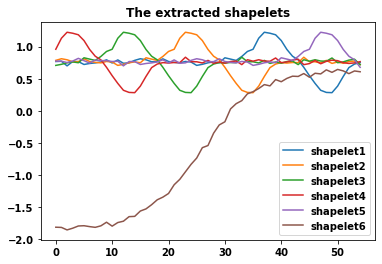

In [44]:
channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

In [45]:
# test the correlation of the shapelets
from src.util import max_corr
K = round(K_star*Q)

corr_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(len(S)):
        corr_matrix[i,j] = max_corr(S[i], S[j])
print(corr_matrix)

[[1.         0.99507604 0.99101817 0.97843046 0.64988246 0.33645872]
 [0.99507604 1.         0.99605401 0.98344562 0.63598961 0.34084517]
 [0.99101817 0.99605401 1.         0.98783033 0.63460305 0.34363539]
 [0.97843046 0.98344562 0.98783033 1.         0.62385909 0.33585822]
 [0.64988246 0.63598961 0.63460305 0.62385909 1.         0.48744564]
 [0.33645872 0.34084517 0.34363539 0.33585822 0.48744564 1.        ]]


#### Shapelets with correlation filtering + distance filtering

Filter those shapelets whose max-lag correlation $\hat{\rho}$ with the previous-discovered ones is > threshold.
\begin{equation}
\hat{\rho} = max_{l} \rho[l] =  max_{l} \frac{1}{L} \hat{s}_{n+1}[l] * \hat{s}_{j}[-l]  
\end{equation}
where $\hat{s}_{n+1}$ is the new candidate shapelet after normalization, $\hat{s}_j$, $j \le n$ is any of the previously discovered shapelets after normalization, L is their length, l is the lag and * the discrete convolution operation.

In [46]:
K = round(K_star * Q)
pos_boundary = None
corr_threshold = 0.8
# just filter the scored candidates in different ways
shapelets = extractor.get_top_candidates(K, pos_boundary, corr_threshold, reverse)
S = shapelets.sequences
print(f'Positions of the shapelets {shapelets.positions}')
print(f'Scores {shapelets.scores}')

Candidates are being filtered by a correlation threshold of 0.8
Positions of the shapelets [159 199 151  42  25  59]
Scores [0.03082866 0.01672882 0.01598372 0.01155427 0.00583644 0.00397394]


In [49]:
# np.save(f'../Results/Trace34/s_reverse={reverse}_corr_threshold={corr_threshold}_L=55', S)
# in case shapelets are already saved:
S = np.load(f's_reverse=True_corr_threshold=0.8_L=55.npy')

# set manually the shapelets in extractor
extractor.shapelets = Candidateset()
extractor.shapelets.sequences = S

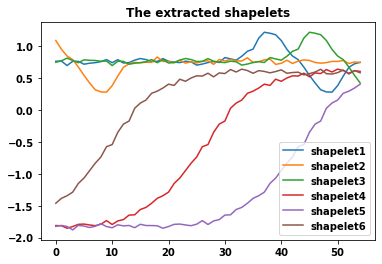

In [47]:
channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

In [48]:
# test the correlation of the shapelets
from src.util import max_corr
K = round(K_star*Q)

corr_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(len(S)):
        corr_matrix[i,j] = max_corr(S[i], S[j])
print(corr_matrix)

[[1.         0.75040025 0.7412892  0.33645872 0.51913573 0.54490191]
 [0.75040025 1.         0.58133428 0.42192359 0.2772835  0.71380115]
 [0.7412892  0.58133428 1.         0.40624798 0.68455234 0.26570861]
 [0.33645872 0.42192359 0.40624798 1.         0.79694996 0.79458705]
 [0.51913573 0.2772835  0.68455234 0.79694996 1.         0.56101177]
 [0.54490191 0.71380115 0.26570861 0.79458705 0.56101177 1.        ]]


In [50]:
# keep non correlated shapelets
extractor.shapelets = Candidateset()
extractor.shapelets.sequences = S

## Anomaly detection using OCSVM

Transform the dataset:

In [51]:
# transform both train and test 
X_train_transform, X_test_transform = extractor.transform()
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (11, 6)
Type and shape of transformed test data <class 'numpy.ndarray'> (89, 6)


Choose how many extracted shapelets to take (2 for visualization purposes):

In [60]:
K = round(K_star*Q)
print('The maximum number of shapelets that can be taken is', K)
n_shap = 2 # n_shap must be <= K
X_train_transform = X_train_transform[:,0:n_shap]
X_test_transform = X_test_transform[:,0:n_shap]

The maximum number of shapelets that can be taken is 6


Fit the OCSVM in transformed space:

In [72]:
ocsvm = OneClassSVM(nu=alpha, kernel='linear')

# fit the model
ocsvm.fit(X_train_transform)

OneClassSVM(kernel='linear', nu=0.1)

EVALUATE the prediction:

In [73]:
## TRAIN
# BALANCED ACCURACY
y_train_predict = ocsvm.predict(X_train_transform)
train_ba = balanced_accuracy_score(y_train_anomaly, y_train_predict)
print("OCSVM train balanced accuracy:", train_ba)

# AUC
y_train_scores = ocsvm.decision_function(X_train_transform)
auc_train = roc_auc_score(y_train_anomaly, y_train_scores)
print("OCSVM train AUC:", auc_train)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("OCSVM train F1 score:", f1_train)

## TEST
# BALANCED ACCURACY
y_test_predict = ocsvm.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("OCSVM test balanced accuracy:", test_ba)

# AUC
y_test_scores = ocsvm.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("OCSVM test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict)
print("OCSVM test F1 score:", f1_test)

OCSVM train balanced accuracy: 0.9
OCSVM train AUC: 1.0
OCSVM train F1 score: 0.888888888888889
OCSVM test balanced accuracy: 0.85
OCSVM test AUC: 1.0
OCSVM test F1 score: 0.8235294117647058


Confusion matrix

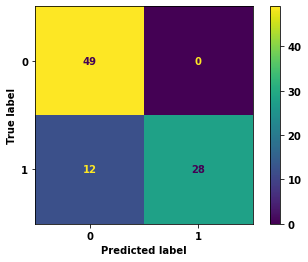

In [74]:
# Confusion matrix for test 
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

ROC and overlapping histograms plot

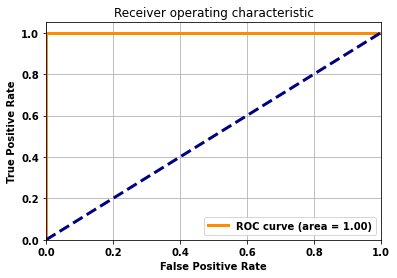

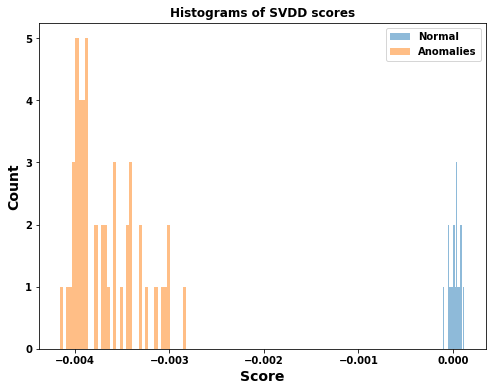

In [75]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()
# plt.savefig('ROC_test.png')

# OVERLAPPING HISTOGRAMS PLOT of SVDD scores (test data)

plt.figure(figsize=(8,6))
plt.hist(y_test_scores[y_test_anomaly==1], bins=40, alpha=0.5, label="Normal")
plt.hist(y_test_scores[y_test_anomaly==-1], bins=40, alpha=0.5, label="Anomalies")

plt.xlabel("Score", size=14)
plt.ylabel("Count", size=14)
plt.title("Histograms of SVDD scores", fontweight="bold")
plt.legend(loc='upper right')
plt.show()

### PLOTS (first two coordinates in shapelet transformed space):

NOTE: if were taken more than 2 shapelets the SVDD boundaries are plotted but they do not indicate the correct boundary in the true points in greater dimension (the points are collapsed in the plane as if their other coordinates were equal to zero)

TRAIN DATA and SVDD boundary

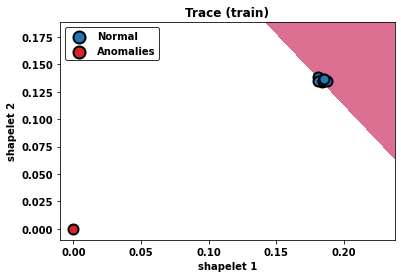

In [78]:
x_max = max(X_train_transform[:,0])+0.05
y_max = max(X_train_transform[:,1])+0.05
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_train = y_train_anomaly == 1
nIndex_train = y_train_anomaly == -1


plt.figure()
plt.title(f"{data_name} (train)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_train_transform[pIndex_train, 0], X_train_transform[pIndex_train, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_train_transform[nIndex_train, 0], X_train_transform[nIndex_train, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                    markerscale=1.2, fancybox=True)
plt.xlim((-0.01, x_max))
plt.ylim((-0.01, y_max))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()

TEST DATA and SVDD boundary

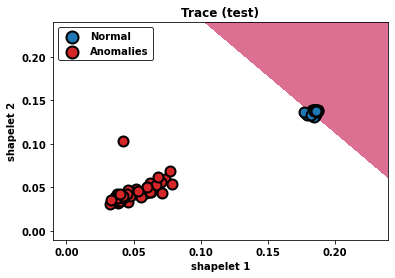

In [81]:
x_max = max(X_test_transform[:,0])+0.1
y_max = max(X_test_transform[:,1])+0.1
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_test = y_test_anomaly == 1
nIndex_test = y_test_anomaly == -1
auc_test = np.around(auc_test, 3)
plt.figure()
plt.title(f"{data_name} (test)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_test_transform[pIndex_test, 0], X_test_transform[pIndex_test, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_test_transform[nIndex_test, 0], X_test_transform[nIndex_test, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                     markerscale=1.2, fancybox=True)

plt.xlim((-0.01, y_max))
plt.ylim((-0.01, y_max))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()